<center><h1><b><u>BA2MOTIFS</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [231]:
#BA2MOTIFS and Custom BA2MOTIFS
import torch
from torch_geometric.datasets import BA2MotifDataset, ExplainerDataset
from torch_geometric.data import Data, Dataset
from torch.utils.data import ConcatDataset, Subset
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.utils import is_undirected, degree, to_networkx, from_networkx, to_dense_adj
import matplotlib.pyplot as plt

#Custom BA2MOTIFS
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif, CycleMotif

#BA2MOTIFS graph from scratch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx #focuses on network analysis and graph theory; can create/visualize graphs
import inspect #for viewing source code
import pprint
from tqdm import tqdm
import pickle
import random
from dataclasses import dataclass

#Classifier
import torch.nn as nn
from torch.nn import Linear, Sequential
import torch_geometric
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, global_max_pool, global_mean_pool

#Fine tuning
import copy

#Other
import warnings

## __Visualizing BA Graph__

In [33]:
#Max pooling operation not supported on mps
device = torch.device('cpu')

In [460]:
def visualize_graph(G, title = '', color = 'lightblue', position = None):
    if not isinstance(G, nx.Graph):
        G = to_networkx(G, to_undirected=True)
    pos = nx.kamada_kawai_layout(G)
    if position is None:
        nx.draw(G, pos, with_labels=False, node_color=color, node_size=200, font_weight='bold', width = 3)
        plt.title(title)
    else:
        nx.draw(G, pos, ax=position, with_labels=False, node_color=color, node_size=200, font_weight='bold', width = 3)
        position.set_title(title)

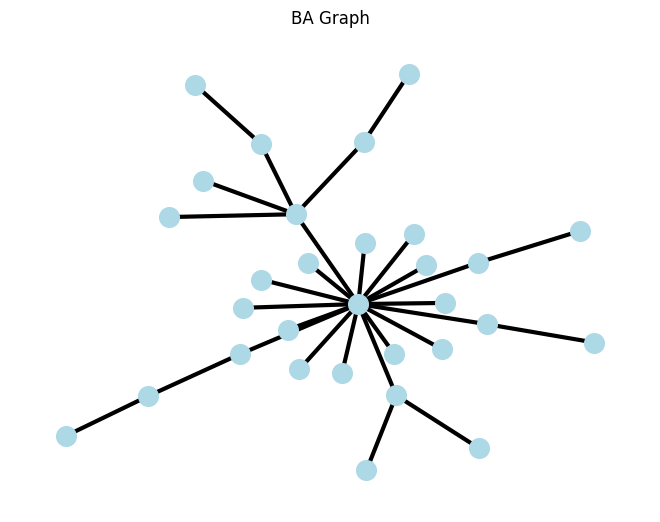

In [459]:
G = nx.barabasi_albert_graph(30, 1)
visualize_graph(G, title = "BA Graph", color = 'lightblue')

## __BA2MOTIF Dataset__

### __Analyze Degree Count__

In [ ]:
ba2motifs = BA2MotifDataset(root='../data/BA2MOTIF', transform=T.ToUndirected()) #makes sure all graphs are undirected

In [37]:
def degree_distribution(graph):
    deg = degree(graph.edge_index[0], num_nodes=graph.num_nodes).long() #deg[i] is degree of node i
    degree_counts = torch.bincount(deg) #tensor where degree_counts[i] = nodes with degree i
    print("Degree distribution:")
    for degre, count in enumerate(degree_counts):
        if count > 0:
            print(f"{count.item()} nodes have degree {degre}")

    plt.figure(figsize=(6, 4))
    plt.bar(range(len(degree_counts)), degree_counts.numpy()) #degree_counts is height of each bar
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title('Degree Distribution')
    plt.show()

Degree distribution:
12 nodes have degree 1
8 nodes have degree 2
3 nodes have degree 3
1 nodes have degree 4
1 nodes have degree 9


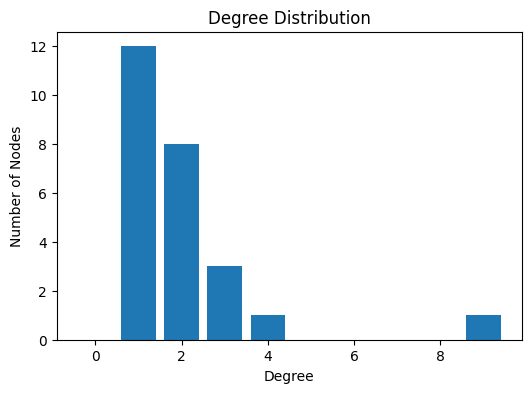

In [38]:
degree_distribution(ba2motifs[0])

### __Visualize Dataset Elements__

In [376]:
def side_by_side(graph1, graph2, title1='', title2=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    visualize_graph(graph1, title1, 'lightblue', ax1)
    visualize_graph(graph2, title2, 'lightgreen', ax2)
    
    plt.tight_layout()
    plt.show()

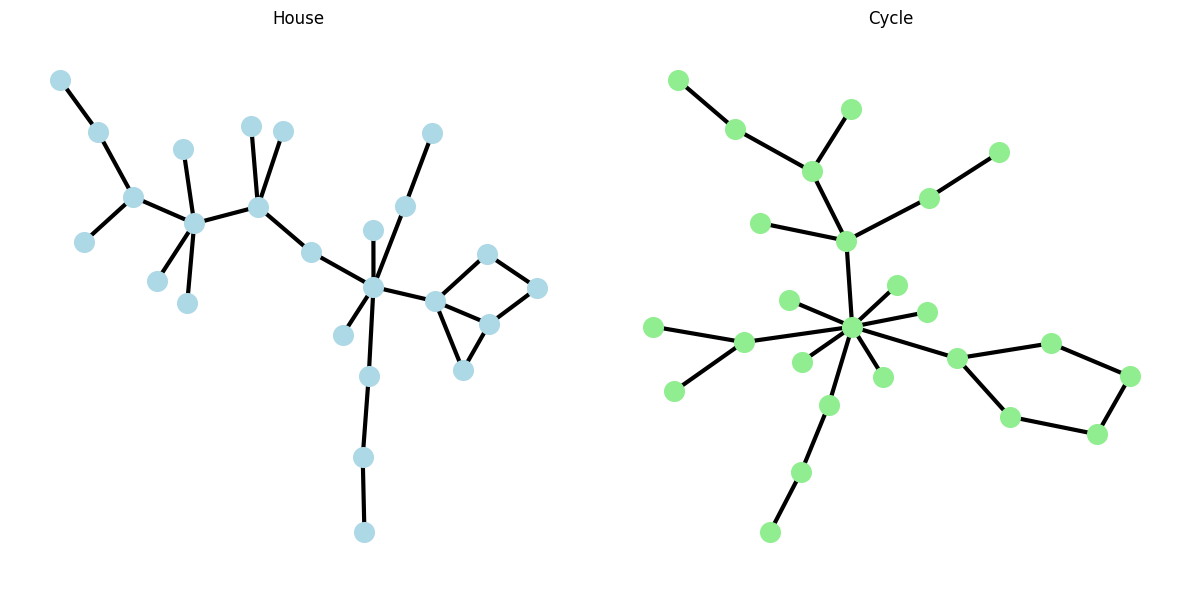

In [468]:
cycle_graph = next(graph for graph in ba2motifs if graph.y.item() == 0)
house_graph = ba2motifs[511] #1 -> house; next() gets next item of iterator that satisfies condition

side_by_side(house_graph, cycle_graph, title1='House', title2='Cycle')

## __BA2Motif from Scratch__

### __Methods to Create the Dataset__

In [43]:
'''Common in Python to group related functions in a module not encapsulated in a class. NodeView node order is correct since dictionary order is 
by insertion but don't rely on this in an algorithm.'''

def create_house_motif():
    house = nx.Graph()
    house.add_edges_from([ #isomorphically a house, 4 nodes in cycle with 2 connected to 5th node
        (0, 1), (1, 2), (2, 3), (3, 0),  # square base
        (1, 4), (2, 4)  # roof
    ])
    return house

def create_cycle_motif(size):
    cycle = nx.Graph()

    cycle.add_nodes_from(range(size))
    
    for i in range(size - 1):
        cycle.add_edge(i, i+1)
    cycle.add_edge(size - 1, 0) #connect last to first to make cycle
    
    return cycle


#Give all nodes same features, otherwise it's "cheating" by labeling the answer; adding features here instead of randomly in class so it is more flexible
def add_node_features(G, motif_nodes):
    for node in G.nodes():
        G.nodes[node]['motif'] = 1

def add_edge_features(G, motif_edges):
    for u, v in G.edges():
        if (u,v) in motif_edges:
            G[u][v]['motif'] = 1
        else:
            G[u][v]['motif'] = 0


def attach_motif(G, motif):
    orig_num_nodes = G.number_of_nodes() #len(graph._node)
    orig_nodes = list(G.nodes())

    motif_node_mapping = {old: orig_num_nodes + map for map, old in enumerate(motif.nodes())} #shifts motif indices by n so it doesn't override current edges
    mapped_motif_nodes = motif_node_mapping.values()
    
    #Create a copy of the motif and add it to existing graph data (still no edge connecting motif to original graph)
    G.add_nodes_from(mapped_motif_nodes)

    #Map and add edges
    motif_edge_mapping = {(u,v): (u + orig_num_nodes, v + orig_num_nodes) for (u, v) in motif.edges()}
    mapped_motif_edges = motif_edge_mapping.values()
    G.add_edges_from(mapped_motif_edges) 
    
    #Choose attachment point and connect motif
    attachment_point = random.choice(orig_nodes) #chooses random element of the list of node id's as attachment point
    random_motif_node = random.choice(list(mapped_motif_nodes)) 

    #Add attachment point
    G.add_edge(attachment_point, random_motif_node) #attachment point between original graph and motif is random


    #Add features
    add_node_features(G, mapped_motif_nodes)
    add_edge_features(G, mapped_motif_edges)

    return G

def generate_ba2motif_dataset(num_graphs, n, m, cycle_size, motif_prob):
    dataset = [] #list of graphs
    labels = []
    
    for i in range(num_graphs):
        ba_graph = nx.barabasi_albert_graph(n, m)
        
        if random.random() < motif_prob: #random number from 0-1; works by Law of Large Numbers
            motif = create_cycle_motif(cycle_size)
            label = 0
        else:
            motif = create_house_motif()
            label = 1  # House motif label is 1
        
        ba_motif_graph = attach_motif(ba_graph, motif)
        
        dataset.append(ba_motif_graph)
        labels.append(label)
    
    return dataset, labels

### __Defining the Class__

#### __Approach 1: Using @dataclass__

In [44]:
@dataclass(init=True, repr=True, eq=False) #forms init, repr automatically; typehints required;  type hints make code more legible, ignored by Python interpreter
class BA2MOTIFDatasetD(Dataset): #D - data class
    num_graphs: int
    n: int
    m: int
    cycle_size: int = 6
    motif_prob: float = 0.5

    def __post_init__(self):
        super().__init__() #good practice to initialize parent class (DataSet); need to initialize them for inherited methods to work
        self.dataset = self.generate_data() #depends on the fields, put in post init since it is after they are set

    def generate_data(self):
        dataset, labels = generate_ba2motif_dataset(self.num_graphs, self.n, self.m, self.cycle_size, self.motif_prob)
        data_list = []
        for graph, label in zip(dataset, labels):
            data = from_networkx(graph) #converts networkx to torch Data instance
            data.x = torch.full((data.num_nodes, 1), 1)  # Random node features; probably not necessary
            data.y = torch.tensor([label], dtype=torch.long)
            data_list.append(data)
        return data_list

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

### __Approach 2: Using a Class__

In [45]:
class BA2MOTIFDatasetS(Dataset): #S - Standard
    def __init__(self, num_graphs, n, m, cycle_size, motif_prob: float = 0.5): #optional
        
        """
        (Practicing formal documentation)
        Initializes BA2MOTIF dataset.

        Args:
            num_graphs (int): Number of graphs in the dataset.
            n (int): Number of nodes in each BA graph.
            m (int): Number of edges to attach from a new node to existing nodes.
            cycle_size (int): Size of the cycle motif.
            motif_prob (float): Probability of attached motif being cycle motif
        """

        super().__init__()
        self.num_graphs = num_graphs #calls __setattr__ if it exists; object.__setattr__ directly modifies __dict__
        self.n = n
        self.m = m
        self.cycle_size = cycle_size
        self.motif_prob = motif_prob

        self.dataset = self.generate_data() #[(nxgraph, label)...]

    def generate_data(self):
        nx_graphs, labels = generate_ba2motif_dataset(self.num_graphs, self.n, self.m, 
                                                    self.cycle_size, self.motif_prob) #creates nx graphs
        dataset = []
        for nx_graph, label in tqdm(zip(nx_graphs, labels), total = len(labels), desc="Creating Dataset", unit = " Graphs", colour="green", ncols=100):
            data = from_networkx(nx_graph)  # converts networkx to torch Data instance; used debugging to see name and dimensions of data object
            
            data.x = data.motif.unsqueeze(1).float()  # change shape from 1D tensor to 2D: [num_nodes, 1]
            #data.x = torch.ones((data.num_nodes, 1), dtype=torch.float) #Other option if features not created when generating dataset

            del data.motif #removes this attribute from namespace, not necessarily memory
        
            #Most GNN don't use edge features
            data.edge_attr = data.edge_motif.unsqueeze(1).float()
            del data.edge_motif

            data.y = torch.tensor([label], dtype=torch.long)
            
            dataset.append(data)
        return dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __repr__(self):
        return (f"{type(self).__name__}(num_graphs={self.num_graphs}, n={self.n}, m={self.m}, " #newline character only added explicitly, Python concacetenates these into singlestrin
                f"cycle_size={self.cycle_size})")

In [221]:
num_graphs = 1000
n = 20
m = 1
cycle_size = 5

### __Approach 3: Functions__

In [222]:
#custom_ba2 = BA2MOTIFDatasetS(num_graphs = 1000, n = 20, m = 1, cycle_size = 5)
'''Above is how it would be created if a class was used. However, for simplicity, the same custom dataset as PGExplainer will be used. Since PGExplainer code is not 
compatible from a dataset that is instantiated, we will create the dataset without the above classes.'''

nx_graphs, labels = generate_ba2motif_dataset(num_graphs, n, m, cycle_size, motif_prob = 0.5) #creates nx graphs

#Convert to Data objects
dataset = []
for nx_graph, label in tqdm(zip(nx_graphs, labels), total = len(labels), desc="Creating Dataset", unit = " Graphs", colour="green", ncols=100):
    data = from_networkx(nx_graph)  # converts networkx to torch Data instance; used debugging to see name and dimensions of data object
    
    data.x = data.motif.unsqueeze(1).float()  # change shape from 1D tensor to 2D: [num_nodes, 1]
    #data.x = torch.ones((data.num_nodes, 1), dtype=torch.float) #Other option if features not created when generating dataset
    del data.motif #removes this attribute from namespace, not necessarily memory

    #Most GNN don't use edge features
    data.edge_attr = data.edge_motif.unsqueeze(1).float()
    del data.edge_motif

    data.adj = to_dense_adj(data.edge_index)
    data.y = torch.tensor([label], dtype=torch.long)
    
    dataset.append(data)
ba2 = dataset

Creating Dataset: 100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 2360.49 Graphs/s]


### __Serializing the Dataset__

In [238]:
'''Serializing saves data to disk in byte stream (binary data more compact than text data); like MNIST from scratch. No whitespaces or other transformations necessary
to decode/deserialize the data so it is also faster.'''

#torch.save(ba2, '../data/BA2MOTIF/custom-ba2.pt')

### __Loading the Dataset__

In [239]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    ba2 = torch.load('../data/BA2MOTIF/custom-ba2.pt')

### __Analyzing Custom BA2Motif Graph__

In [240]:
def print_matrix(name, matrix):
        print(name)
        for row in matrix:
            print(" ".join(str(int(element.item())) for element in row))
        print()

In [245]:
graph = ba2[122]
motif = 'House' if graph.y.item() == 1 else 'Cycle'

#Attributes automatically assigned when creating data instance
print(f"Number of nodes: {graph.num_nodes}")
print(f"Node features shape: {graph.x.shape}") #shape is tensor attribute
print_matrix("Node feature matrix:", graph.x)

print(f"Number of edges: {graph.num_edges}")
print(f"Edge index shape: {graph.edge_index.shape}\n")

print(f"Attached motif: {motif}")

Number of nodes: 25
Node features shape: torch.Size([25, 1])
Node feature matrix:
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

Number of edges: 52
Edge index shape: torch.Size([2, 52])

Attached motif: House


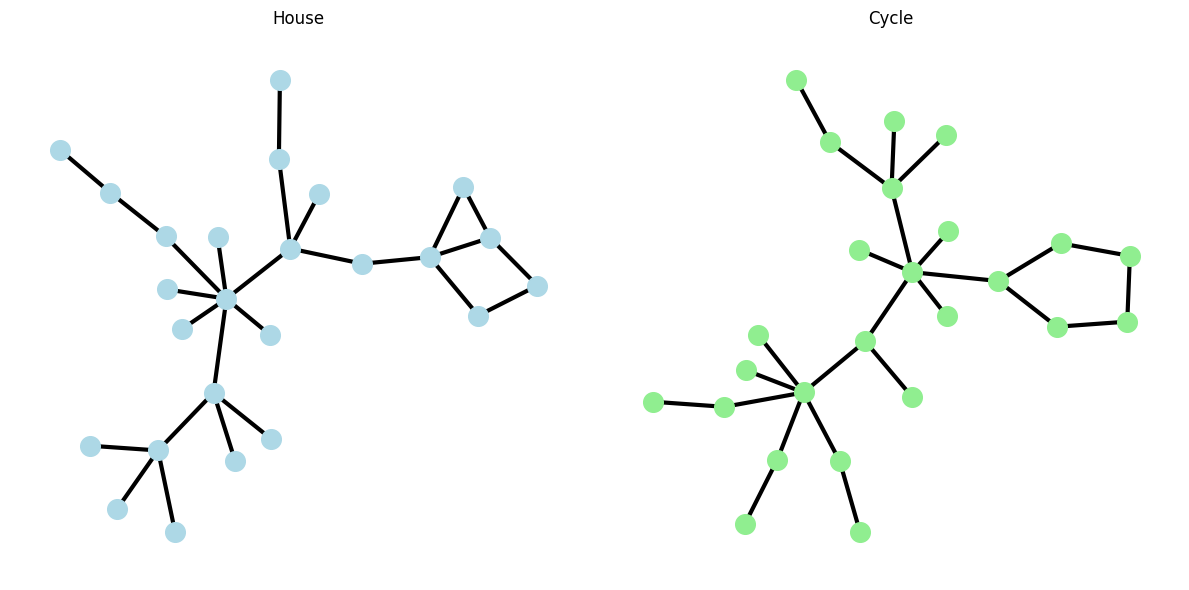

In [463]:
cycle_graph = next(graph for graph in ba2 if graph.y.item() == 0)
house_graph = next(graph for graph in ba2 if graph.y.item() == 1) #0 -> house; next() gets next item of iterator that satisfies condition

side_by_side(house_graph, cycle_graph, title1='House', title2='Cycle')

## __Creating GCN Graph Classifier__

### __Defining the Model__

In [246]:
'''Sequential adds a fixed number of layers into one object. ModuleList is dynamic so layers can easily be a hyperparameter. After mutliple layers of message passing
even if the feature is same for all nodes/edges, the values start to get a specific pattern for certain structures like motifs. GIN structure exploits graph structure well.'''
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)

        self.bn1 = nn.BatchNorm1d(hidden_dim) #normalizes the feature vector
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        self.fc1 = nn.Linear(hidden_dim * 2, 2)
        
    
    #Message pass and create node embeddings
    def embedding(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index))) #x is for one batch; do
        return F.relu(self.bn2(self.conv2(x, edge_index)))
    
    def forward(self, data): #data is a graph and all attributes
        #edge_index, edge_attr = torch_geometric.utils.add_self_loops(data.edge_index, num_nodes=data.x.size(0)) #self loops message passing automatic for GCNConv layer
        x = self.embedding(data.x, data.edge_index)

        #Graph embedding
        x_max = global_max_pool(x, data.batch) #captures most promiment features; data.batch is tensor saying which nodes belong to which graph
        x_mean = global_mean_pool(x, data.batch) #captures average representation
        g_embedding = torch.cat([x_max, x_mean], dim=1) #graph embedding; more diverse
        
        #Classification
        return self.fc1(g_embedding) 

### __Preparing the Data__

In [247]:
full_train_dataset = ba2[:int(len(ba2)*.8)]
test_dataset = ba2[int(len(ba2)*.8):]

train_dataset = full_train_dataset[:int(len(full_train_dataset)*.8)]
val_dataset = full_train_dataset[int(len(full_train_dataset)*.8):]

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

640
160
200


In [248]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
full_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

### __Training__

In [249]:
num_node_features = ba2[0].x.size(-1) #ba2[0].x.size(-1) = 1; 1 constant feature for all nodes

model = GCN(input_dim=num_node_features, hidden_dim=32) 
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
cross_entropy = torch.nn.CrossEntropyLoss()

In [98]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, data.y) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader.dataset)

In [110]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            pred = out.argmax(dim=1) #dim1 is for certain batch; index of max val will be predicted class (0 == cycle, 1 == house)
            correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

#### __Training with Train/Validation Subsets__

In [ ]:
num_epochs = 200
for epoch in range(num_epochs):
    loss = train(model, full_train_loader, cross_entropy, optimizer)
    train_acc = evaluate(model, full_train_loader)
    val_acc = evaluate(model, val_loader)
    if epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%')

#### __Final Training with Full Train Dataset__

In [116]:
model = GCN(input_dim = ba2[0].x.size(-1), hidden_dim=32) #feature dimension
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
cross_entropy = torch.nn.CrossEntropyLoss()

In [117]:
num_epochs = 200
for epoch in range(num_epochs):
    loss = train(model, full_train_loader, cross_entropy, optimizer)
    train_acc = evaluate(model, full_train_loader)
    val_acc = evaluate(model, val_loader)
    if epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%')

Epoch: 001, Loss: 0.0218, Train Acc: 48.12%
Epoch: 200, Loss: 0.0005, Train Acc: 99.88%


### __Loading Model__

In [254]:
def load_model(filename, classifier = "GIN"):
    if classifier == "GCN":
        model = GCN(input_dim=1, hidden_dim=32)
    elif classifier == "GIN":
        model = GIN(num_features=1)
    model.load_state_dict(torch.load(f'../models/BA2-Scratch/{filename}', weights_only=True))
    model.eval()
    model = model.to(device)
    return model

In [255]:
filename = "GCN-100.pth"

In [256]:
model = load_model(filename, classifier = "GCN")

### __Evaluation__

In [257]:
train_acc = evaluate(model, train_loader)
print(f'Train Accuracy: {train_acc*100:.2f}%')

test_acc = evaluate(model, test_loader)
print(f'Test Accuracy: {test_acc*100:.2f}%')

Train Accuracy: 99.84%
Test Accuracy: 100.00%


### __Saving Model__

In [119]:
def save_model(model, filename):
    torch.save(model.state_dict(), f'../models/BA2-Scratch/{filename}')

In [259]:
filename = f"GCN-{test_acc*100:.2f}.pth"
filename

'GCN-100.00.pth'

In [260]:
#save_model(model, filename)

### __Inference on New Out of Distribution Graph__

#### __Creating New BA2MOTIF Graph__

In [123]:
custom_ba_graph = nx.barabasi_albert_graph(30, 1) #instead of 20, see how it performs on slightly OOD data

if random.random() < 0.5: #random number from 0-1
    motif = create_cycle_motif(cycle_size)
    label = 0
else:
    motif = create_house_motif()
    label = 1  # House motif label is 1

ba_motif_graph = attach_motif(custom_ba_graph, motif)

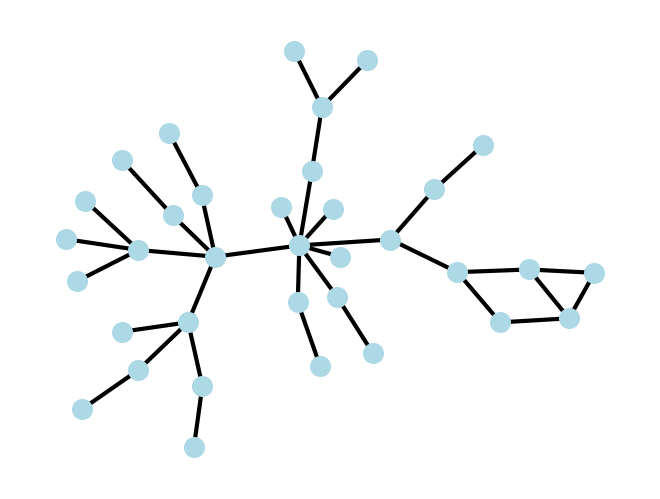

In [464]:
visualize_graph(ba_motif_graph)

#### __Converting to Torch__

In [127]:
#Convert to torch
data = from_networkx(custom_ba_graph)  # converts networkx to torch Data instance; used debugging to see name and dimensions of data object

data.x = data.motif.unsqueeze(1).float()  # change shape from 1D tensor to 2D: [num_nodes, 1]
data.edge_attr = data.edge_motif.unsqueeze(1).float()
data.y = torch.tensor([label], dtype=torch.long)

#### __Inputting into Model__

In [261]:
#Input to GCN
outputs = model(data)  #[batch_size, num_classes]; batch_size automatically done by PyTorch
probabilities = F.softmax(outputs, dim=1)  # dim=1 -> 2nd dim -> class dimension
prob_house = probabilities[0][1] #First batch, house probability (2nd class)

#Output
print(f"Probability of house: {prob_house*100:.2f}%")
print(f"Probability of cycle: {100 - prob_house*100:.2f}%")
motif = 'House' if prob_house > 0.5 else 'Cycle'
print(f"Attached motif: {motif}")

Probability of house: 100.00%
Probability of cycle: 0.00%
Attached motif: House


## __Create GIN Classifier__

### __Define the Model__

In [159]:
class GIN(torch.nn.Module):
    def __init__(self, num_features, dropout_rate = 0.2, num_classes = 2, pretrained_model = False):
        super(GIN, self).__init__()

        self.nn1 = Sequential(
            Linear(num_features, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            Linear(32, 16),
            nn.ReLU())

        self.conv1 = GINConv(self.nn1)
        self.bn1 = nn.BatchNorm1d(16)

        self.nn2 = Sequential(
            Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            Linear(16, 16),
            nn.ReLU())
        
        self.conv2 = GINConv(self.nn2)
        self.bn2 = nn.BatchNorm1d(16)

        self.fc1 = Linear(32, num_classes) #2 classes

        #Ensure original model isn't altered during fine-tuning
        if pretrained_model:
            temp = torch.load(f'../models/BA2-Scratch/{pretrained_model}', weights_only=True)
            cloned_state_dict = copy.deepcopy(temp)
            self.load_state_dict(cloned_state_dict)
            
            
            self.freeze_layers()
            self.fc1 = Linear(32, 2) #Common to freeze earlier layers; replace desired layer (starting from scratch) for fine tuning

    def freeze_layers(self):
        for name, param in self.named_parameters():
                param.requires_grad = True if 'fc1' else False #Freeze every layer except final MLP classification layer

    def node_embedding(self, x, edge_index):
        # Process through GIN layers
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        return x
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch #extracts feature matrix from graph, edge info, batch indices
        node_embeddings = self.node_embedding(x, edge_index) #reduces dimension of nodes and edges

        x_max = global_max_pool(node_embeddings, batch)
        x_mean = global_mean_pool(node_embeddings, batch)
        x = torch.cat([x_max, x_mean], dim=1) #combines these two poolings into single tensor

        return self.fc1(x)

### __Training__

In [143]:
model = GIN(num_features=ba2[0].x.size(1))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
cross_entropy = torch.nn.CrossEntropyLoss()

#### __Training with Train/Validation Subsets__

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    loss = train(model, train_loader, cross_entropy, optimizer)
    train_acc = evaluate(model, train_loader)
    val_acc = evaluate(model, val_loader)
    if epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%')

#### __Final Training with Full Train Data__

In [144]:
num_epochs = 100

for epoch in range(num_epochs):
    loss = train(model, full_train_loader, cross_entropy, optimizer)
    train_acc = evaluate(model, full_train_loader)
    if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
        print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%')

Epoch: 010, Loss: 0.0215, Train Acc: 53.75%
Epoch: 020, Loss: 0.0131, Train Acc: 84.25%
Epoch: 030, Loss: 0.0030, Train Acc: 98.25%
Epoch: 040, Loss: 0.0017, Train Acc: 96.50%
Epoch: 050, Loss: 0.0014, Train Acc: 97.38%
Epoch: 060, Loss: 0.0010, Train Acc: 99.75%
Epoch: 070, Loss: 0.0009, Train Acc: 99.00%
Epoch: 080, Loss: 0.0006, Train Acc: 99.25%
Epoch: 090, Loss: 0.0005, Train Acc: 98.88%
Epoch: 100, Loss: 0.0004, Train Acc: 99.88%


### __Saving/Loading Model__

In [263]:
filename = "GIN-99.50.pth"

In [147]:
#save_model(model, filename)

In [264]:
model = load_model(filename, classifier = "GIN")

### __Evaluation__

In [266]:
train_acc = evaluate(model, train_loader)
print(f'Train Accuracy: {train_acc*100:.2f}%')

test_acc = evaluate(model, test_loader)
print(f'Test Accuracy: {test_acc*100:.2f}%')

Train Accuracy: 99.22%
Test Accuracy: 99.50%


## __Fine-Tuning Classifer with Data Augmentation__

### __Defining Augmentations__

In [267]:
def node_feature_masking(data: Data, mask_rate: float = 0.1) -> Data: #returns Data
    data = copy.deepcopy(data)
    num_nodes = data.num_nodes
    mask = torch.rand(num_nodes) > mask_rate #row vector
    data.x = data.x * mask.unsqueeze(1) #column vector due to added dimension
    return data


'''Edge perturubation only done on non-motif edges to preserve the motifs. When creating dataset, motifs were added to graph last and thus have the labels 20-24,
so the pertubation will avoid these nodes in the edge index.'''

def edge_perturbation(data, p_add = 0.1, p_remove = 0.1):
    # Create new object so original dataset is preserved
    data = copy.deepcopy(data)
    edge_index = data.edge_index
    
    # Identify motif edges (contain nodes 20-24) with boolean mask
    motif_mask = (edge_index[0] >= 20) | (edge_index[1] >= 20)
    
    #Create "remove mask" but replace False for motif edges with True to keep label unaltered  
    remove_mask = torch.rand(edge_index.size(1)) > p_remove
    remove_mask = remove_mask | motif_mask 
    
    #PyTorch uses boolean indexing to remove False and keep True elements
    edge_index = edge_index[:, remove_mask]
    
    #Randomly add edges while preserving label
    num_new_edges = int(p_add * edge_index.size(1))
    new_edges = torch.randint(0, 20, (2, num_new_edges)) #create new valid edge index of shape 2 x num_new_edges
    edge_index = torch.cat([edge_index, new_edges], dim=1) #concatenate the two along the columns
    
    data.edge_index = edge_index #certain functions like cat create new tensor so edge and data.edge reference different tensors
    return data

In [268]:
def augment_graph(data: Data) -> Data:
    augmentations = [edge_perturbation, node_feature_masking]    
    # Randomly choose one or more augmentations to apply
    num_augs = random.randint(1, len(augmentations))
    chosen_augs = random.sample(augmentations, num_augs)

    augmented_data = copy.deepcopy(data) #copy not limited to Pytorch objects; .clone() is shallow copy for gradient and other info
    for aug in chosen_augs: #aug is a function in the function list chosen_augs
        augmented_data = aug(augmented_data)
    
    return augmented_data

### __Preparing the Data__

#### __Creating the Augmented Data__

In [269]:
def permute_dataset(dataset):
    permuted_indices = torch.randperm(len(dataset)).tolist() #list of integer indices
    return [dataset[i] for i in permuted_indices]

PROP_NORM = 0.0

def augment_set(dataset):
    augmented_dataset = []
    permuted = permute_dataset(dataset)

    #Leave PROP_NORM of fine-tune training dataset as normal
    for data in permuted[:int(len(permuted) * PROP_NORM)]:
        augmented_dataset.append(data)

    #Augmented the rest of the graphs
    for data in permuted[int(len(permuted) * PROP_NORM):]:
        augmented_data = augment_graph(data)
        augmented_dataset.append(augmented_data)
    return augmented_dataset

#### __Splitting the Data__

In [270]:
full_train_dataset = ba2[:int(len(ba2)*.8)]
test_dataset = ba2[int(len(ba2)*.8):]

#Subset full_train for initial training
train_dataset = full_train_dataset[:int(len(full_train_dataset)*.8)]
val_dataset = full_train_dataset[int(len(full_train_dataset)*.8):]

#Augment the training sets 
aug_full_train = augment_set(full_train_dataset)
aug_train = augment_set(train_dataset)

print(len(aug_full_train))
print(len(aug_train))
print(len(val_dataset))

800
640
160


### __Training__

In [271]:
device = torch.device('cpu')

In [272]:
aug_loader = DataLoader(aug_train, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

full_aug_loader = DataLoader(aug_full_train, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [273]:
filename = "GIN-99.50.pth"

#Use pretrained parameter for fine tuning a pretrained model
model = GIN(num_features=1, pretrained_model = filename) #loads the pretrained model and freezes all but last MLP
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #lower learning rate for fine tuning
cross_entropy = torch.nn.CrossEntropyLoss()

#### __Training with Train/Validation Subsets__

In [210]:
#Accuracy low to start since it is on the augmneted dataset
num_epochs = 30

for epoch in range(num_epochs):
    loss = train(model, aug_loader, cross_entropy, optimizer)
    train_acc = evaluate(model, aug_loader)
    val_acc = evaluate(model, val_loader)
    if epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%')

Epoch: 001, Loss: 0.0316, Train Acc: 40.31%, Val Acc: 35.00%
Epoch: 030, Loss: 0.0125, Train Acc: 78.75%, Val Acc: 97.50%


#### __Final Training with Full Training Set__

In [211]:
filename = "GIN-99.50.pth"
model = GIN(num_features = 1, pretrained_model = filename) #loads the pretrained model and freezes all but last MLP
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
cross_entropy = torch.nn.CrossEntropyLoss()

In [212]:
num_epochs = 20
for epoch in range(num_epochs):
    loss = train(model, full_aug_loader, cross_entropy, optimizer)
    train_acc = evaluate(model, full_aug_loader)
    if epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.0201
Epoch: 020, Loss: 0.0089


In [275]:
model = load_model(aug_filename, classifier = "GIN")

In [276]:
train_acc = evaluate(model, train_loader) 
print(f'Train Accuracy: {train_acc*100:.2f}%') #Improved test accuracy with fine tuning

test_acc = evaluate(model, test_loader) 
print(f'Test Accuracy: {test_acc*100:.2f}%') #Improved test accuracy with fine tuning

Train Accuracy: 99.38%
Test Accuracy: 100.00%


### __Saving__

In [274]:
aug_filename = f"GIN-aug-fine-tuned-100.00.pth"
aug_filename

'GIN-aug-fine-tuned-100.00.pth'

In [218]:
#save_model(model, aug_filename)